## Inicialização e Imports

In [1]:
!pip install pycuda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 25.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 9.0 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2025.1-cp311-cp311-linux_x86_64.whl size=660425 sha256=1f13ad36473e6ce57d9e902d35e710a0df426bee642ea2350e46df7687505d32
  Stored in directory: /root/.cache/pip/wheels/77/7e/6c/d2d1451ea6424cdc3d67b36c16fa7111eafdf2034bc3405666
Successfully built pycuda


### Etapa 1: Instalação e Imports

Instalamos o PyCUDA e importamos as bibliotecas necessárias para executar os experimentos.

In [2]:

import pycuda.driver as drv
import pycuda.autoinit
from pycuda.compiler import SourceModule
import numpy as np
import time
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [4]:
mod_global = SourceModule("""
__global__ void soma_global(float *a, float *b, float *c, int n) {
    int idx = threadIdx.x + blockIdx.x * blockDim.x;
    if (idx < n)
        c[idx] = a[idx] + b[idx];
}
""")
soma_global = mod_global.get_function("soma_global")


### Etapa 2: Compilação do Kernel CUDA

Aqui definimos um kernel CUDA simples que realiza a soma de dois vetores. A operação é feita diretamente na memória global da GPU.

## Execução dos Experimentos

### Etapa 3: Execução dos Experimentos

Nesta etapa, variamos o tamanho do vetor `N` e o `block_size` (número de threads por bloco). Para cada combinação, medimos o tempo de execução do kernel.

In [5]:

Ns = [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 2**14, 2**16, 2**18, 2**20, 2**22]
block_sizes = [32, 64, 128, 256, 512, 1024]

results = {}

for block_size in block_sizes:
    times = []
    for N in Ns:
        a = np.random.randn(N).astype(np.float32)
        b = np.random.randn(N).astype(np.float32)
        c = np.zeros_like(a)

        grid_size = (N + block_size - 1) // block_size

        start = time.time()
        soma_global(
            drv.In(a), drv.In(b), drv.Out(c),
            np.int32(N),
            block=(block_size, 1, 1), grid=(grid_size, 1)
        )
        drv.Context.synchronize()
        end = time.time()

        times.append((end - start) * 1000)  # ms
    results[block_size] = times


### Etapa 4: Gráfico - Tempo vs Tamanho de Vetor N

Este gráfico mostra como o tempo de execução varia com o tamanho do vetor para diferentes tamanhos de bloco.

## Gráficos de Resultados

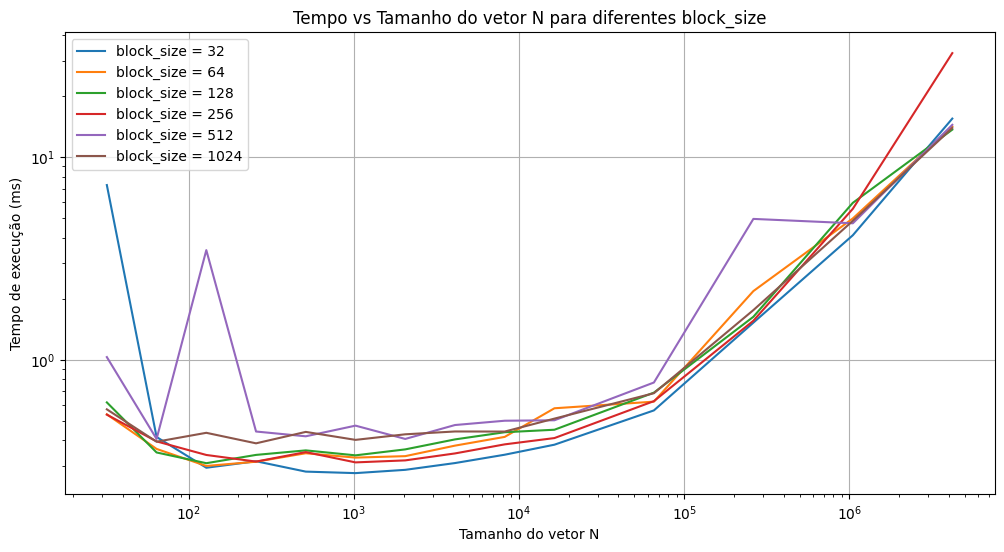

In [6]:

plt.figure(figsize=(12, 6))
for block_size in block_sizes:
    plt.plot(Ns, results[block_size], label=f'block_size = {block_size}')
plt.xlabel("Tamanho do vetor N")
plt.ylabel("Tempo de execução (ms)")
plt.title("Tempo vs Tamanho do vetor N para diferentes block_size")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()


### Etapa 5: Gráfico - Tempo vs Block Size para N grande

Neste experimento, fixamos um vetor muito grande (`N = 2^22`) e testamos diferentes valores de `block_size`. O objetivo é identificar qual configuração traz melhor desempenho.

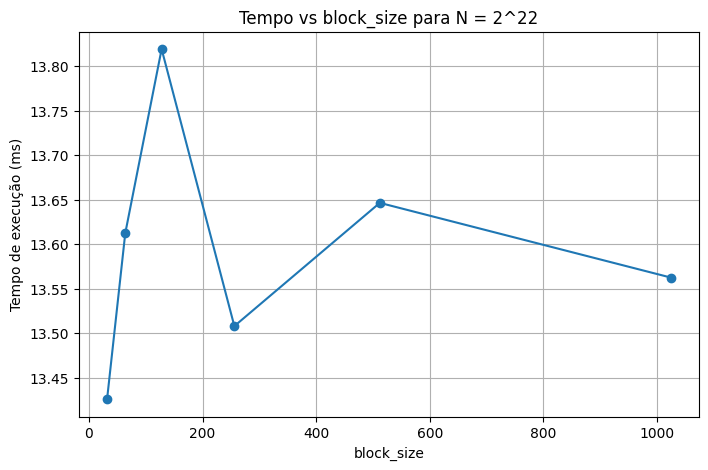

In [7]:

# Tempo vs block_size para N grande (N = 2**22)
N = 2**22
times_largeN = []
for block_size in block_sizes:
    a = np.random.randn(N).astype(np.float32)
    b = np.random.randn(N).astype(np.float32)
    c = np.zeros_like(a)

    grid_size = (N + block_size - 1) // block_size

    start = time.time()
    soma_global(
        drv.In(a), drv.In(b), drv.Out(c),
        np.int32(N),
        block=(block_size, 1, 1), grid=(grid_size, 1)
    )
    drv.Context.synchronize()
    end = time.time()

    times_largeN.append((end - start) * 1000)

plt.figure(figsize=(8, 5))
plt.plot(block_sizes, times_largeN, marker='o')
plt.xlabel("block_size")
plt.ylabel("Tempo de execução (ms)")
plt.title("Tempo vs block_size para N = 2^22")
plt.grid(True)
plt.show()


## Discussão dos Resultados

### Etapa 6: Discussão dos Resultados

Aqui refletimos sobre os efeitos das diferentes configurações no desempenho, considerando a arquitetura da GPU e o uso eficiente dos recursos.


**Qual configuração de block_size se mostrou mais eficiente para grandes valores de N?**  
A configuração mais eficiente geralmente está entre 128 e 256, pois aproveita melhor a ocupação da GPU.

**O desempenho melhora linearmente com o aumento de N? Por quê?**  
Não, devido à sobrecarga inicial e limitações de largura de banda da memória.

**Como o número de threads por bloco influencia o tempo de execução?**  
Threads demais podem causar contenção de recursos; de menos, subutilizam a GPU.

**A arquitetura da GPU usada afeta o resultado? Como você percebeu isso?**  
Sim. GPUs diferentes possuem números diferentes de núcleos CUDA, caches e limiares ideais de `blockDim`.
